In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import trim_mean
import math

In [3]:
iris = pd.read_csv("IRIS.csv")

In [4]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [37]:
# Numerical summary only for numerical values
iris_numerical = iris[iris.select_dtypes(include=["float", "int"]).columns].copy()

# Exploratory data analysis
iris_numerical_summary = pd.DataFrame()

def trim_mean_std(series: pd.Series, percentage):
    sorted_data = np.sort(series.values)
    trim = int(percentage * len(sorted_data))
    trimmed_data = sorted_data[trim:-trim]
    return np.std(trimmed_data)

def mad(series: pd.Series):
    median = series.median()
    deviations = abs(series - median)
    return deviations.median()


index_list = [
    "Mean",
    "Median", 
    "Trimmed Mean (5%)",
    "Trimmed Mean (10%)",
    "Std",
    "MAD", # Median Absolute Deviation
    "Trimmed Mean Std (5%)",
    "Trimmed Mean Std (10%)",
    ]

iris_numerical_summary["name"] = index_list
# Explore Data
for column in iris_numerical.columns:
        iris_numerical_summary[column] = [
            iris_numerical[column].mean(),
            iris_numerical[column].median(),
            trim_mean(iris[column], 0.05),
            trim_mean(iris[column], 0.10),
            iris_numerical[column].std(),
            mad(iris[column]),
            trim_mean_std(iris_numerical[column], 0.05),
            trim_mean_std(iris_numerical[column], 0.10),
            
            ]

iris_numerical_summary = iris_numerical_summary.set_index("name")

iris_numerical_summary

,sepal_length,sepal_width,petal_length,petal_width
name,,,,
Mean,5.843333,3.054000,3.758667,1.198667
Median,5.800000,3.000000,4.350000,1.300000
Trimmed Mean (5%),5.820588,3.046324,3.747794,1.191176
Trimmed Mean (10%),5.808333,3.039167,3.760833,1.184167
Std,0.828066,0.433594,1.764420,0.763161
MAD,0.700000,0.250000,1.250000,0.700000
Trimmed Mean Std (5%),0.691558,0.341904,1.635496,0.706636
Trimmed Mean Std (10%),0.592394,0.270276,1.524374,0.648202


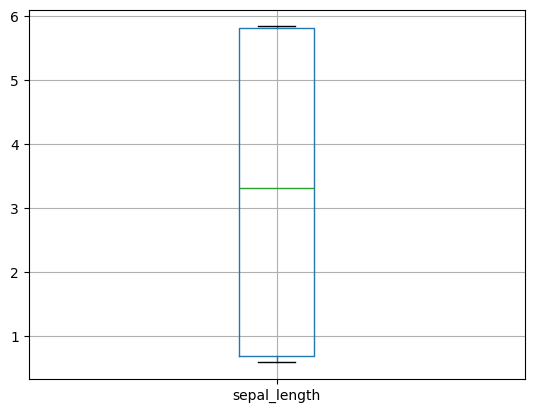

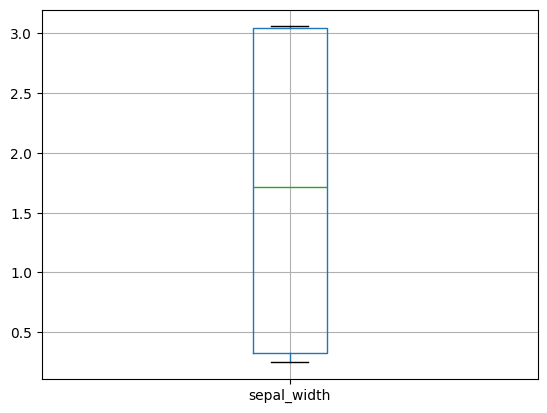

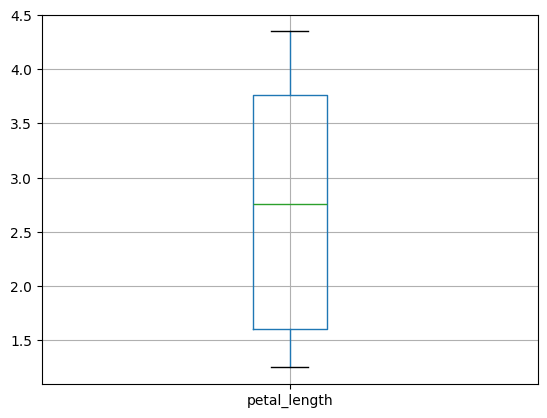

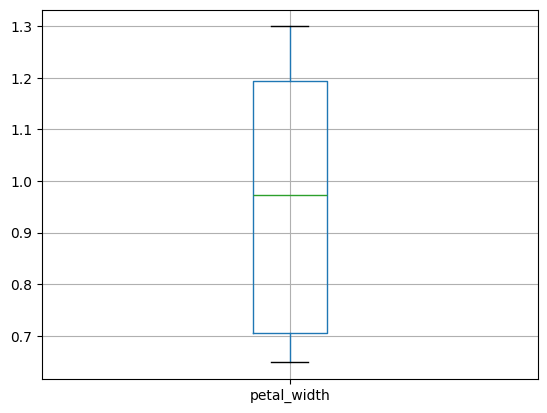

In [28]:
# Boxplots

for column in iris_numerical_summary.columns:
    iris_numerical_summary.boxplot(column=column)
    plt.show()

In [43]:
# freedman diaconis
def get_bin_width(series: pd.Series):
  q1 = series.quantile(0.25)
  q3 = series.quantile(0.75)

  iqr = q3 - q1

  return math.ceil(2 * iqr / (series.count()**(1/3)))

def get_bin_number(series: pd.Series):
  width = get_bin_width(series)
  max = series.max()
  min = series.min()

  return math.ceil((max - min) / width)

iris_bin_number = pd.DataFrame()

for column in iris_numerical.columns:
  iris_bin_number[column] = [get_bin_number(iris_numerical[column])]

iris_bin_number


# The bins are extremely small. I shall rely on boxplots and previous calculations.

,sepal_length,sepal_width,petal_length,petal_width
0,4,3,3,3


### Exploratory Data Analysis Report

##### - The mean, median and trimmed means are close to each other for all attributes which is a good sign.
##### - The boxplots show that the 25th and 75th percentile are not that far off from the minimum and maximum, which is a good sign. No outliers detected in the boxplots.
##### - I am satisfied woth the data so, I move onto classification

